In [58]:
import sys
import pandas as pd
import numpy as np
import time
import imdb
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
pd.options.mode.chained_assignment = None  # default='warn'

In [36]:
import re

#function that uses a regex to extract data we need from various cols in dataset
def extractData(str):
    return re.findall("'name': \'(.+?)\'", str)

In [9]:
#function to get past movie success
def calcPastSuccess(movie, ia):
    start_time = time.time()
    for i in range(8):
        actor = movie['cast'][i]
        filmList = ia.get_person_filmography(actor.getID())['data']['filmography'][0]
        filmography = filmList.get('actor')
        if filmography is None:
            filmography = filmList.get('actress')

        totalRating = 0
        totalBO = 0
        movieCount = 0
        accMovieCount = 0
        for film in filmography:
            if film['kind'] == 'movie':
                film = ia.get_movie(film.getID())
                rating = film.get("rating")
                boxOffice = film.get("box office")
                if boxOffice is not None :
                    gross = boxOffice.get('Cumulative Worldwide Gross')
                else:
                    gross = None

                accMovieCount += 1
                if rating is not None and gross is not None:
                    totalRating += float(rating)
                    gross = gross.split(' ')[0][1:].replace(',','')
                    totalBO += float(gross)
                    movieCount += 1
        if movieCount > 0:
            AvgIMDbScore = totalRating/movieCount
            AvgBO = totalBO/movieCount
        else:
            AvgIMDbScore = 0
            AvgBO = 0
        print("Statistics for", actor)
        print('Number of Movies used in formula: ',movieCount)
        print('Number of Movies Total: ', accMovieCount)
        print("Average IMDb Score: ", AvgIMDbScore)
        pastIMDbFormula = AvgIMDbScore - 10 * (1/3)**movieCount
        pastBoxOfficeFormula = 10* (AvgBO / 100000000) - 10 * (1/3)**movieCount

        print('IMDb Weighted Average Rating for: ', pastIMDbFormula)
        print('Box Office Weighted Average for: ', pastBoxOfficeFormula)
        print("--- %s minutes ---" % ((time.time() - start_time)/60))
        print()

In [10]:
#Load in the data
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
#Look at all of the columns
print(train.columns)

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')


In [11]:
#Drop columns we will not be using and inspect the head of df
train = train.drop(columns=[ 'homepage', 'poster_path', 'original_title', 'overview','tagline','Keywords'])
train.head(10)

,id,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,title,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",tt0093743,en,0.743274,NaN,NaN,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pinocchio and the Emperor of the Night,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",tt0431021,en,7.286477,"[{'name': 'Ghost House Pictures', 'id': 768}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Possession,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075
7,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",tt0391024,en,1.949044,NaN,NaN,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Control Room,"[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",tt0117110,en,6.902423,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/16/96,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Muppet Treasure Island,"[{'cast_id': 1, 'character': 'Long John Silver...","[{'credit_id': '52fe43c89251416c7501deb3', 'de...",34327391
9,10,NaN,6000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",tt0310281,en,4.672036,"[{'name': 'Castle Rock Entertainment', 'id': 97}]","[{'iso_3166_1': 'US', 'name': 'United States o...",4/16/03,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Mighty Wind,"[{'cast_id': 24, 'character': 'Jonathan Steinb...","[{'credit_id': '52fe45609251416c750545b3', 'de...",18750246


In [12]:
print(train.shape)

(3000, 17)


In [13]:
print(train.describe())

                id        budget   popularity      runtime       revenue
count  3000.000000  3.000000e+03  3000.000000  2998.000000  3.000000e+03
mean   1500.500000  2.253133e+07     8.463274   107.856571  6.672585e+07
std     866.169729  3.702609e+07    12.104000    22.086434  1.375323e+08
min       1.000000  0.000000e+00     0.000001     0.000000  1.000000e+00
25%     750.750000  0.000000e+00     4.018053    94.000000  2.379808e+06
50%    1500.500000  8.000000e+06     7.374861   104.000000  1.680707e+07
75%    2250.250000  2.900000e+07    10.890983   118.000000  6.891920e+07
max    3000.000000  3.800000e+08   294.337037   338.000000  1.519558e+09


In [15]:
#replace all NA values to empty strings so we can extract data cleanly
train.genres = train.genres.fillna("")
train.production_companies = train.production_companies.fillna("")
train.production_countries = train.production_countries.fillna("")
train.spoken_languages = train.spoken_languages.fillna("")

In [16]:
#use helper function to extract data from necessary features
train['genres_reform'] = train['genres'].apply(lambda x: extractData(x))
train['production_companies_reform'] = train['production_companies'].apply(lambda x: extractData(x))
train['production_countries_reform'] = train['production_countries'].apply(lambda x: extractData(x))
train['spoken_languages_reform'] = train['spoken_languages'].apply(lambda x: extractData(x))

In [17]:
train.head()

,id,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,...,spoken_languages,status,title,cast,crew,revenue,genres_reform,production_companies_reform,production_countries_reform,spoken_languages_reform
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,[Comedy],"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],[English]
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,"[Comedy, Drama, Family, Romance]",[Walt Disney Pictures],[United States of America],[English]
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,[Drama],"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],[English]
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,3.174936,,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,"[Thriller, Drama]",[],[India],"[English, हिन्दी]"
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,1.148070,,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,"[Action, Thriller]",[],[South Korea],[한국어/조선말]


In [18]:
# you can easily index through it now, like so:
print(train['genres_reform'][1])
for genre in train['genres_reform'][1]:
    print(genre)

['Comedy', 'Drama', 'Family', 'Romance']
Comedy
Drama
Family
Romance


In [19]:
#making a copy so i can play with stuff and show you how i've done some things without changing the real dataset
df = train.copy(deep=True)

In [20]:
# Will likely make this another separate file as a helper function, can be used for several of the features
def unpackCol(list, df):
    for i in range(len(df)):
        for name in list[i]:
            if name not in df.columns:
                df[name] = 0
            df[name][i] = 1
    return df

In [21]:
#example of using it to unpack the genres 
df = unpackCol(df['genres_reform'], df)

In [23]:
#here's what it did
print(df.columns)
print()
print(df['Drama'])
print()
# This total number lines up with what other people had too for amount of dramas, so assuming it is correct
print('Total number of Dramas: ', sum(df['Drama']))

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'title', 'cast', 'crew', 'revenue', 'genres_reform',
       'production_companies_reform', 'production_countries_reform',
       'spoken_languages_reform', 'Comedy', 'Drama', 'Family', 'Romance',
       'Thriller', 'Action', 'Animation', 'Adventure', 'Horror', 'Documentary',
       'Music', 'Crime', 'Science Fiction', 'Mystery', 'Foreign', 'Fantasy',
       'War', 'Western', 'History', 'TV Movie'],
      dtype='object')

0       0
1       1
2       1
3       1
4       0
       ..
2995    0
2996    1
2997    0
2998    0
2999    0
Name: Drama, Length: 3000, dtype: int64

Total number of Dramas:  1531


In [24]:
# here is a quick line to sort out the collection stuff
df.belongs_to_collection = df.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)

In [54]:
print(df.belongs_to_collection)
print()
print('Total movies in collections:', sum(df.belongs_to_collection))
print('Total movies not in collections:', (df.belongs_to_collection == 0).sum(axis=0))

0       1
1       1
2       0
3       0
4       0
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: belongs_to_collection, Length: 3000, dtype: int64

Total movies in collections: 604
Total movies not in collections: 2396


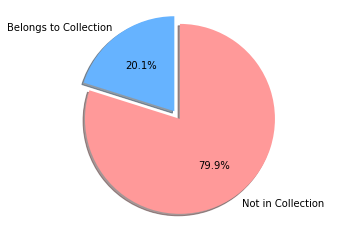

In [64]:
# plotting belongs to collection data
labels = 'Belongs to Collection', 'Not in Collection'
btc = [sum(df.belongs_to_collection), (df.belongs_to_collection == 0).sum(axis=0)]
explode = (0.1, 0)
cs=['#66b3ff', '#ff9999']

fig, ax = plt.subplots()
ax.pie(btc, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=cs)
ax.axis('equal') # ensures chart is a circle

plt.show()

From a total of 3000 data points, 604 or 20.1% were a part of a collection of films, while the other 2396 or 79.9% were not. Belonging to a collection has the potential to be an important feature when predicting revenue as customers may be more likely to pay for a movie-going experience when it is the next iteration of a series into which they have already invested time and money. The origin of serial media is largely accredited to The Pickwick Papers, written by Charles Dickens in 1836, and has since boomed all the way into the 21st century. Given the current and historic popularity of the format, it is hypothesized that belonging to a collection will indicate a positive correlation with revenue.

In [26]:
# here is my lambda for featurizing the genre data - works like a dream with the reformed data! JSON be darned
df_test = df['genres_reform'].apply(frozenset).to_frame(name='genre')
for genre in frozenset.union(*df_test.genre):
    df_test[genre] = df_test.apply(lambda _: int(genre in _.genre), axis=1)
df_test.head()

,genre,History,Adventure,Documentary,Thriller,Family,Animation,Crime,Foreign,War,...,Western,Mystery,TV Movie,Action,Romance,Horror,Music,Comedy,Drama,Fantasy
0,(Comedy),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,"(Romance, Family, Drama, Comedy)",0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2,(Drama),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,"(Thriller, Drama)",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,"(Thriller, Action)",0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [27]:
# stripping the 'tt' from the idmb id, only used in url and easier to get movies without it
df['imdb_id'] = df['imdb_id'].str[2:]
df['imdb_id']

0       2637294
1       0368933
2       2582802
3       1821480
4       1380152
         ...   
2995    0109403
2996    2364975
2997    0116908
2998    0343135
2999    1600195
Name: imdb_id, Length: 3000, dtype: object

In [28]:
# new feature for a count of the number of spoken languages
df['num_languages'] = df.spoken_languages_reform.apply(lambda x: len(x))

In [29]:
# new feature for a count of the number of production studios
df['num_studios'] = df.production_companies_reform.apply(lambda x: len(x))

In [30]:
df.head()

,id,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,...,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie,num_languages,num_studios
0,1,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",2637294,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,...,0,0,0,0,0,0,0,0,1,3
1,2,1,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0368933,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,...,0,0,0,0,0,0,0,0,1,1
2,3,0,3300000,"[{'id': 18, 'name': 'Drama'}]",2582802,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,...,0,0,0,0,0,0,0,0,1,3
3,4,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",1821480,hi,3.174936,,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,...,0,0,0,0,0,0,0,0,2,0
4,5,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",1380152,ko,1.148070,,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,...,0,0,0,0,0,0,0,0,1,0


In [31]:
df.describe()

,id,belongs_to_collection,budget,popularity,runtime,revenue,Comedy,Drama,Family,Romance,...,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie,num_languages,num_studios
count,3000.000000,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,0.201333,2.253133e+07,8.463274,107.856571,6.672585e+07,0.342667,0.510333,0.086667,0.190333,...,0.096667,0.075000,0.010333,0.077333,0.033333,0.014333,0.044000,0.000333,1.443000,2.683667
std,866.169729,0.401063,3.702609e+07,12.104000,22.086434,1.375323e+08,0.474680,0.499977,0.281393,0.392630,...,0.295553,0.263435,0.101143,0.267164,0.179535,0.118881,0.205129,0.018257,0.880725,1.994056
min,1.000000,0.000000,0.000000e+00,0.000001,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,750.750000,0.000000,0.000000e+00,4.018053,94.000000,2.379808e+06,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1500.500000,0.000000,8.000000e+06,7.374861,104.000000,1.680707e+07,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,2250.250000,0.000000,2.900000e+07,10.890983,118.000000,6.891920e+07,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000
max,3000.000000,1.000000,3.800000e+08,294.337037,338.000000,1.519558e+09,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,16.000000


In [32]:
# release date data manipulation
# naming a date-specific dataframe for housekeeping
df_date = df['release_date']

# converting to datetime format, with .dt used for accessing quantities
df_date = pd.to_datetime(df_date)
df_date.dt
print(df_date)

0      2015-02-20
1      2004-08-06
2      2014-10-10
3      2012-03-09
4      2009-02-05
          ...    
2995   1994-04-22
2996   2013-03-28
2997   1996-10-11
2998   2004-01-16
2999   2011-09-22
Name: release_date, Length: 3000, dtype: datetime64[ns]


In [33]:
# possible output options
print(df_date.dt.year) # absolutely necessary
print(df_date.dt.dayofweek) # friday night hits!
print(df_date.dt.dayofyear) # it's a christmas miracle
print(df_date.dt.weekofyear) # idk might be interesting

0       2015
1       2004
2       2014
3       2012
4       2009
        ... 
2995    1994
2996    2013
2997    1996
2998    2004
2999    2011
Name: release_date, Length: 3000, dtype: int64
0       4
1       4
2       4
3       4
4       3
       ..
2995    4
2996    3
2997    4
2998    4
2999    3
Name: release_date, Length: 3000, dtype: int64
0        51
1       219
2       283
3        69
4        36
       ... 
2995    112
2996     87
2997    285
2998     16
2999    265
Name: release_date, Length: 3000, dtype: int64
0        8
1       32
2       41
3       10
4        6
        ..
2995    16
2996    13
2997    41
2998     3
2999    38
Name: release_date, Length: 3000, dtype: int64
